In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import umap
import nltk
import spacy
import string

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('hsbc_comments.csv')
df.head()

,message
0,I would like to say a massive thank you to HSB...
1,"""Imaginations Run Wild?"" my backside- try gett..."
2,If you would send me the neccesary number I wo...
3,"Just past 1 hour waiting again, for the 3rd ti..."
4,Melanie Humberstone


In [3]:
df.message.replace("\S*http\S*" , "", regex=True, inplace = True)
df.message.replace("_" , " ", regex=True, inplace = True)
df.message.replace("^" , " ", regex=True, inplace = True)

In [4]:
for i in string.punctuation:
    try:
        df.fb_comment.replace(f"\{i}" , "", regex=True, inplace = True)
    except: pass

In [5]:
df.message.head()

0     I would like to say a massive thank you to HS...
1     "Imaginations Run Wild?" my backside- try get...
2     If you would send me the neccesary number I w...
3     Just past 1 hour waiting again, for the 3rd t...
4                                  Melanie Humberstone
Name: message, dtype: object

In [6]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', str(text))
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [7]:
def word_root(text):
    list_data3=[]
    text = remove_unicode(text)
    doc = spaci(text)
    for token in doc:
        if token.text.isalpha():
            lemma = token.lemma_
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)
df.message = df.message.apply(lambda x: word_root(str(x).lower()))  

In [8]:
df.message[0]

'I would like to say a massive thank you to hsbc and the telephone staff someone be use my card and you help I thorough the process of stop it immediately you be friendly and efficient I will always bank hsbc'

In [9]:
df_clean = df.message
df_clean.shape

(990,)

In [10]:
df_clean = df_clean.dropna()
df_clean.shape

(990,)

In [11]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [12]:
from sentence_transformers import SentenceTransformer

In [13]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [14]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

In [15]:
# embeddings1[embeddings1.argmax()]

In [16]:
model=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

In [17]:
model=SentenceTransformer('roberta-large-nli-stsb-mean-tokens')
embeddings3 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

In [18]:
model=SentenceTransformer('allenai-specter')
embeddings4 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

In [19]:
UMAP_bert1 = umap.UMAP(n_components=5).fit_transform(embeddings1)

UMAP_bert2 = umap.UMAP(n_components=5).fit_transform(embeddings2)

UMAP_bert3 = umap.UMAP(n_components=5).fit_transform(embeddings3)

UMAP_bert4 = umap.UMAP(n_components=5).fit_transform(embeddings4)

#n_neighbors=10, min_dist=0.0, 

In [39]:
from pyclustertend import hopkins

embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert2" : UMAP_bert2,
              "UMAP_bert3" : UMAP_bert3, "UMAP_bert4" : UMAP_bert4}
              
embeds = {}

for key, emb in embeddings.items():
    embeds[key] = hopkins(emb,emb.shape[0])

embeds
# embeddings[embeds.index(min(embeds))]
# print(f"the hopkins score for embeddings {i} is : {hs}")

{'UMAP_bert1': 0.03865895977210239,
 'UMAP_bert2': 0.021247579213936402,
 'UMAP_bert3': 0.01980537905352982,
 'UMAP_bert4': 0.026406949371167603}

In [40]:
best_embed_name = min(embeds, key=embeds.get)
best_model = embeddings[best_embed_name]
best_embed_name

'UMAP_bert3'

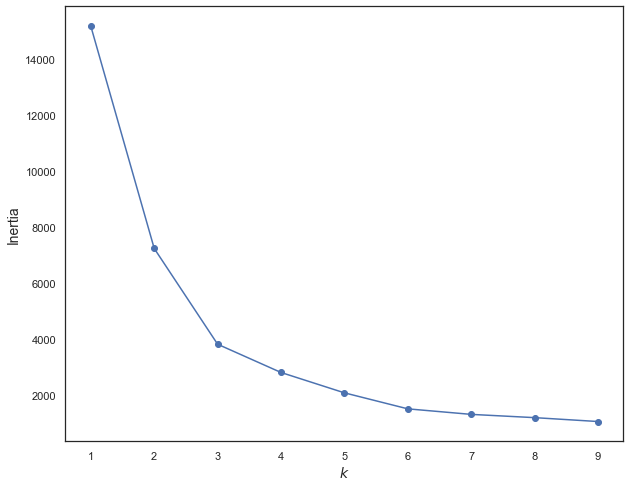

In [41]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [42]:
# # docs = pd.DataFrame(df_clean)
# # docs["cluster"] = cluster
# #deleting junk clusters
# corpus = pd.DataFrame(df_clean)
# corpus["cluster"] = cluster
# indexes = list(corpus[corpus.cluster == 4].index) + list(corpus[corpus.cluster == 1].index)
# best_model = np.delete(best_model, indexes, 0)
# corpus = corpus.drop(axis=0, index=indexes)

In [49]:
len(corpus)

964

In [53]:
cluster = KMeans(n_clusters=5,init="k-means++").fit_predict(best_model)

In [54]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings3)



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='Spectral')
    plt.show()

{0: 403, 1: 15, 2: 120, 3: 441, 4: 11}


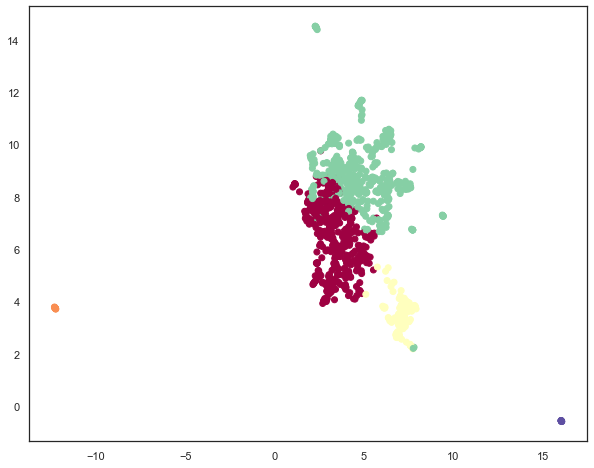

In [55]:
plot()

In [56]:
cluster.shape

(990,)

In [57]:
docs2 = pd.DataFrame(df_clean)
docs2["cluster"] = cluster
labeled_docs = docs2.groupby(["cluster"], as_index=False).agg({"message": " ".join})
labeled_docs.message.replace(r"\S*hsbc\S*", "", regex=True, inplace = True)
labeled_docs.message.replace(r"\S*bank\S*", "", regex=True, inplace = True)
labeled_docs.message.replace(r"\S*barc\S*", "", regex=True, inplace = True)
labeled_docs

,cluster,message
0,0,imagination run wild my try get your basic se...
1,1,
2,2,melanie humberstone brilliant x stay safe our ...
3,3,I would like to say a massive thank you to an...
4,4,bad service two staff member that do have a cl...


In [65]:
labeled_docs.message[4]

'bad service two staff member that do have a clue about how to find a solution to a problem staff i d number and bad service two staff member that do have a clue about how to find a solution to a problem staff i d number and bad service two staff member that do have a clue about how to find a solution to a problem staff i d number and no but I tired of try to sort out my mortgage with you sort your system out and make it all a bit clear for people staff do have a clue so how do you expect customer to understand bad service two staff member that do have a clue about how to find a solution to a problem staff i d number and bad service two staff member that do have a clue about how to find a solution to a problem staff i d number and bad service two staff member that do have a clue about how to find a solution to a problem staff i d number and bad service two staff member that do have a clue about how to find a solution to a problem staff i d number and bad service two staff member that d

In [58]:
from keybert import KeyBERT
array_text = labeled_docs.message.tolist()

model_names = {"model1":'distilbert-base-nli-mean-tokens',
               "model2": "xlm-r-distilroberta-base-paraphrase-v1" ,
               "model3": 'roberta-large-nli-stsb-mean-tokens',
               "model4": "allenai-specter"}
    
print("-"*20,best_embed_name,"-"*20)
kw_extractor = KeyBERT('xlm-r-distilroberta-base-paraphrase-v1')
k = 0
for j in range(len(array_text)):
    k+=1
    keywords = kw_extractor.extract_keywords(array_text[j],top_n=10,min_df=2,stop_words=["gwych","customersshockingsubstandardcustomerservice"])
    if not keywords:
        k -= 1
    else:
        print("Cluster", str(k))
        print([word[0] for word in keywords])

-------------------- UMAP_bert3 --------------------
Cluster 1
['try', 'servicejust', 'account', 'attempt', 'service', 'stay', 'customersyet', 'operate', 'chatreadyou', 'keep']
Cluster 2
['thank', 'excellent', 'grateful', 'great', 'good', 'wonderful', 'awesome', 'lovely', 'brilliant', 'welcome']
Cluster 3
['tack', 'thankfully', 'goodbye', 'card', 'please', 'kindly', 'thank', 'ncp', 'careful', 'call']
Cluster 4
['staff', 'problem', 'service', 'solution', 'clue', 'people', 'bad', 'number', 'customer', 'understand']


In [59]:
kw_extractor = KeyBERT('xlm-r-distilroberta-base-paraphrase-v1')
k = 0
for j in range(len(array_text)):
    k+=1
    keywords = kw_extractor.extract_keywords(array_text[j],top_n=5,min_df=2,keyphrase_ngram_range=(1, 2),
                                             stop_words=["gwych","customersshockingsubstandardcustomerservice"])
    if not keywords:
        k -= 1
    else:
        print("Cluster", str(k))
        print([word[0] for word in keywords])

Cluster 1
['account try', 'service try', 'hour try', 'time try', 'try time']
Cluster 2
['thank you', 'service thank', 'thank to', 'thank for', 'great work']
Cluster 3
['tack send', 'send card', 'please thank', 'send cheque', 'tack']
Cluster 4
['problem staff', 'people staff', 'staff do', 'two staff', 'staff number']


In [66]:
kw_extractor = KeyBERT('xlm-r-distilroberta-base-paraphrase-v1')
k = 0
for j in range(len(array_text)):
    k+=1
    keywords = kw_extractor.extract_keywords(array_text[j],top_n=10,min_df=2,keyphrase_ngram_range=(1, 3),
                                             stop_words=["gwych","customersshockingsubstandardcustomerservice"])
    if not keywords:
        k -= 1
    else:
        print("Cluster", str(k))
        print([word[0] for word in keywords])

Cluster 1
['service benn try', 'my account try', 'account try', 'appalling service try', 'over hour try', 'service be try', 'service try', 'hour try', 'account hey try', 'anymore hour try']
Cluster 2
['service thank you', 'thank you do', 'beautiful service thank', 'great effort hi', 'thank you', 'very grateful appal', 'service thank', 'do good job', 'thank you sir', 'be grateful to']
Cluster 3
['tack send', 'send card and', 'pay my card', 'cancel my card', 'customer my card', 'tell my card', 'block my card', 'close my account', 'and send cheque', 'send card']
Cluster 4
['problem staff', 'problem staff number', 'to problem staff', 'people staff do', 'service two staff', 'for people staff', 'people staff', 'staff do', 'two staff', 'staff number and']
